Following: https://towardsdatascience.com/demystifying-gans-in-tensorflow-2-0-9890834ab3d9

Tf 2.0 for building network and adverserial processes.
Numpy to generate noise.
Matplotlib for saving images.

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

print("Tensorflow: " + tf.__version__)

Tensorflow: 2.0.0


In [30]:
# Few global variables required in the code that follows
BATCH_SIZE = 256
BUFFER_SIZE = 60000
EPOCHES = 300
OUTPUT_DIR = "img" # To store images by generator during training

In [31]:
# Load mnist dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)

(60000, 28, 28)


Before implementing neural network, the data are passed into a `tf.data.Dataset` object. It represents sequence of elements, in which each element contains one or more Tensor object — we’ll use it as an iterator to store our images in batches and loop trough them later. In addition, the images are normalized to be between -1 and 1 (same range which is generated by the uniform distribution).

In [32]:
train_images = train_images.astype("float32")
print(train_images[0])

train_images = (train_images - 127.5) / 127.5

print(train_images[0])

train_dataset = tf.data.Dataset.from_tensor_slices(train_images.reshape(train_images.shape[0],784)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.  

<BatchDataset shapes: (None, 784), types: tf.float32>

Will use tf.keras api for building generator and discriminator classes. In the constructor we are going to define the layers of the network and in the call method the forward pass of the model. We are going to input 100-dimensional noise into the network and output a vector of the size 784. Later, we are going reshape the vector back to a matrix with the dimension of 28x28 (the original size of the images). In addition, the generate_noise method is used to create random data points from the uniform distribution.

In [33]:
class Generator(keras.Model):
    
    def __init__(self, random_noise_size = 100):
        super().__init__(name='generator')
        #layers
        self.input_layer = keras.layers.Dense(units = random_noise_size)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 256)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        self.output_layer = keras.layers.Dense(units=784, activation = "tanh")
        
    def call(self, input_tensor):
        ## Definition of Forward Pass
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        return  self.output_layer(x)
    
    def generate_noise(self,batch_size, random_noise_size):
        return np.random.uniform(-1,1, size = (batch_size, random_noise_size))

## Plotting Noise using generator

In [34]:
generator = Generator()

### Objective of Discriminator
![](https://miro.medium.com/max/910/1*hkgSodUw0ynuhNz8xk-Npg.png)

### Objective of Generator
![](https://miro.medium.com/max/536/1*afFPOyuuldrB4maAljuNHw.png)

The objective function described above is nothing else then binary cross entropy. It takes the noise which is feed into the discriminator and only true labels, because the generator thinks that he produces real images.

In [35]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx) 

Doing the same for the discriminator objective but now we adding the fake and the real loss together. In addition, we add a little bit smoothing to the objective of the real loss, to avoid overfitting.

In [36]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.9):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0. 
    total_loss = real_loss + fake_loss
    
    return total_loss

In [37]:
# Discriminator network
# Input = 784 dim vector, Output = one neuron (tells if image fake or real)

class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        
        #Layers
        self.input_layer = keras.layers.Dense(units = 784)
        self.dense_1 = keras.layers.Dense(units = 128)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 128)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 128)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        self.logits = keras.layers.Dense(units = 1)  # This neuron tells us if the input is fake or real
    def call(self, input_tensor):
          ## Definition of Forward Pass
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.leaky_2(x)
        x = self.leaky_3(x)
        x = self.leaky_3(x)
        x = self.logits(x)
        return x

In [38]:
discriminator = Discriminator()

In [39]:
generator_optimizer = keras.optimizers.RMSprop()
discriminator_optimizer = keras.optimizers.RMSprop()

# Training Step

By using the gradients of the generator and discriminator we are training both networks simultaneously . First, some noise is generated according to the batch size we defined before. Afterwards we’re feeding the real image as well as the fake image into the discriminator and calculate its lost. The last step is to do the same for the generator and to apply those gradients.

In [45]:
@tf.function()
def training_step(generator: Generator, discriminator: Discriminator, images:np.ndarray , k:int =1, batch_size = 32):
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            noise = generator.generate_noise(batch_size, 100)
            g_z = generator(noise)
            d_x_true = discriminator(images) # Trainable?
            d_x_fake = discriminator(g_z) # dx_of_gx

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs


            generator_loss = generator_objective(d_x_fake)
            # Adjusting Gradient of Generator
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 

In [46]:
seed = np.random.uniform(-1,1, size = (1, 100)) # generating some noise for the training

# Training

In [102]:
def training(dataset, epoches):
    for epoch in range(epoches*4):
        for batch in dataset:
            training_step(generator, discriminator, batch ,batch_size = BATCH_SIZE, k = 1)
        ## After ith epoch plot image 
        if (epoch % 50) == 0: 
            fake_image = tf.reshape(generator(seed), shape = (28,28))
            print("{}/{} epoches".format(epoch, epoches))
            #plt.imshow(fake_image, cmap = "gray")
            plt.imsave("{}/{}.png".format(OUTPUT_DIR,epoch),fake_image, cmap = "gray")

In [103]:
training(train_dataset, EPOCHES)

0/300 epoches
50/300 epoches
100/300 epoches
150/300 epoches
200/300 epoches
250/300 epoches
300/300 epoches
350/300 epoches
400/300 epoches
450/300 epoches
500/300 epoches
550/300 epoches
600/300 epoches
650/300 epoches
700/300 epoches
750/300 epoches
800/300 epoches
850/300 epoches
900/300 epoches
950/300 epoches
1000/300 epoches
1050/300 epoches
1100/300 epoches
1150/300 epoches


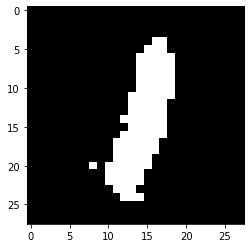

In [160]:
fake_image = generator(np.random.uniform(-1,1, size = (1, 100)))
plt.imshow(tf.reshape(fake_image, shape = (28,28)), cmap="gray")